Lay out the necessary imports

In [1]:
import os
import random
import sys

import librosa
import musdb
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader



Define root directory depending on runtime environment and define the device we're working with.

In [2]:

colab = 'google.colab' in sys.modules

if colab:
    root_dir = "/content/"
else:
    root_dir = ""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

device=device(type='cuda')


Load the MusDB18 DB

In [ ]:
musdb18_train = musdb.DB(root='./musdb18', subsets='train', split='train')
musdb18_valid = musdb.DB(root='./musdb18', subsets='train', split='valid')
musdb18_test = musdb.DB(root='./musdb18', subsets='test')

Preprocess the audio track and the vocals track to the STFT Spectrogram that we will later feed to the CNN.

In [ ]:
def extract_random_chunks(musdb_set, num_chunks, chunk_duration=10.0):
    for _ in tqdm(range(num_chunks)):
        track = random.choice(musdb_set.tracks)
        track.chunk_duration = chunk_duration
        track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)
        if track.chunk_start < 0:
            continue
        x = track.audio.T
        y = track.targets['vocals'].audio.T
        yield x, y, track


def preprocess_and_save_data(musdb_set, save_dir, split, num_chunks, chunk_duration=10.0, sample_rate=22050):
    generator = extract_random_chunks(musdb_set, num_chunks, chunk_duration)
    os.makedirs(f'{save_dir}{split}', exist_ok=True)

    for audio, vocal, track in generator:
        # Convert to mono and resample
        audio = librosa.resample(librosa.to_mono(audio), orig_sr=track.rate, target_sr=sample_rate)
        vocal = librosa.resample(librosa.to_mono(vocal), orig_sr=track.rate, target_sr=sample_rate)

        # Compute the spectrograms
        audio_spec = librosa.stft(audio, n_fft=1024, hop_length=512)[:512, :256]
        vocal_spec = librosa.stft(vocal, n_fft=1024, hop_length=512)[:512, :256]

        # Save
        np.save(f'{save_dir}{split}/audio__{track.name}__{track.chunk_start}.npy', audio_spec)
        np.save(f'{save_dir}{split}/vocal__{track.name}__{track.chunk_start}.npy', vocal_spec)


# Preprocess and save data for each subset
preprocess_and_save_data(musdb18_train, save_dir='./processed/', split='train', num_chunks=7)
preprocess_and_save_data(musdb18_valid, save_dir='./processed/', split='valid', num_chunks=2)
preprocess_and_save_data(musdb18_test, save_dir='./processed/', split='test', num_chunks=1)

In [3]:
class SpectrogramDataset(Dataset):
    def __init__(self, data_dir, split):
        self.data_dir = f'{data_dir}{split}/'
        self.audio_specs = sorted([f for f in os.listdir(self.data_dir) if f.startswith('audio__')])
        self.vocal_specs = sorted([f for f in os.listdir(self.data_dir) if f.startswith('vocal__')])
        print(f'Initialized {split=}: {len(self.audio_specs)=} {len(self.vocal_specs)=}')

    def __len__(self):
        return len(self.audio_specs)

    def __getitem__(self, idx):
        input_spec = np.load(os.path.join(self.data_dir, self.audio_specs[idx]))
        target_spec = np.load(os.path.join(self.data_dir, self.vocal_specs[idx]))
        return torch.tensor(input_spec, dtype=torch.float32).unsqueeze(0), torch.tensor(target_spec, dtype=torch.float32).unsqueeze(0)

# Create DataLoader objects for each subset
train_dataset = SpectrogramDataset('./processed/', split='train')
valid_dataset = SpectrogramDataset('./processed/', split='valid')
test_dataset = SpectrogramDataset('./processed/', split='test')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Initialized split='train': len(self.audio_specs)=7 len(self.vocal_specs)=7
Initialized split='valid': len(self.audio_specs)=2 len(self.vocal_specs)=2
Initialized split='test': len(self.audio_specs)=1 len(self.vocal_specs)=1


torch.Size([1, 512, 256]) torch.Size([1, 512, 256])


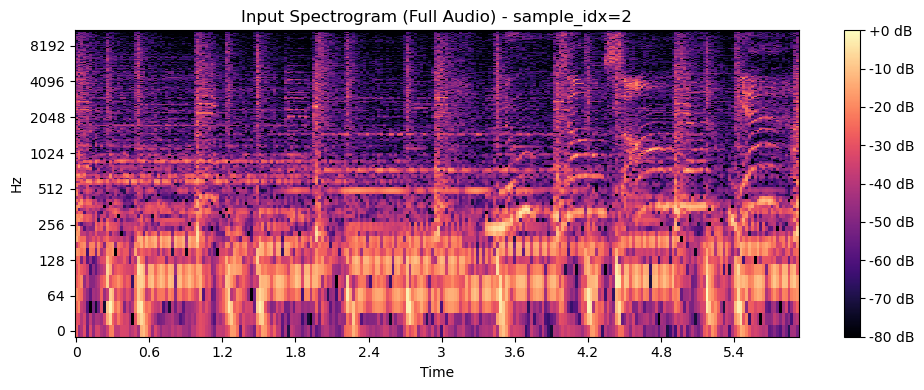

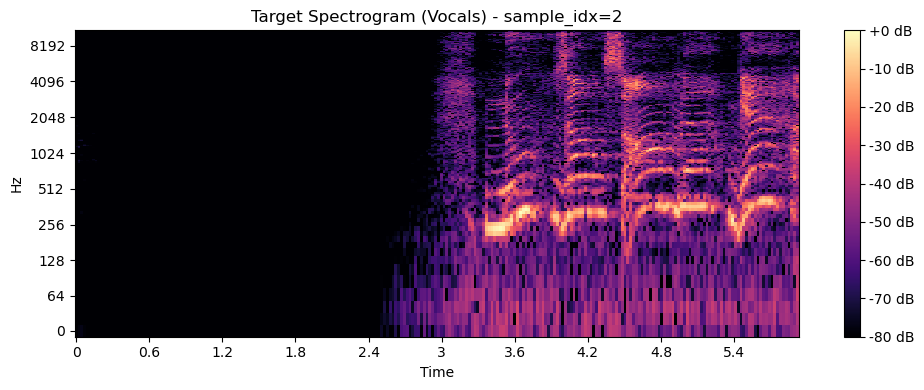

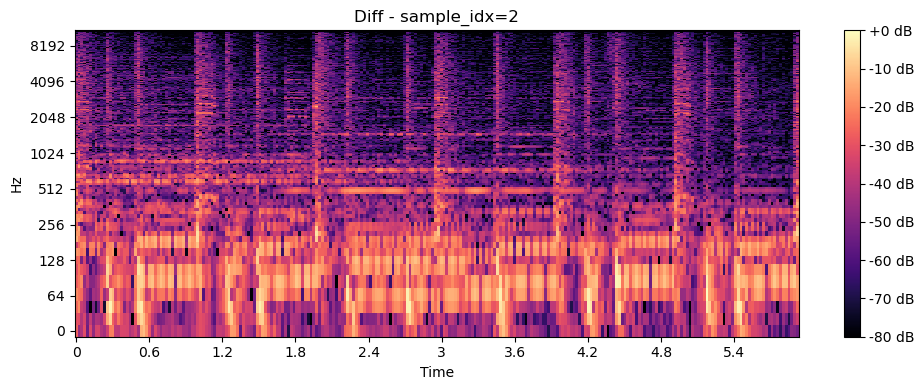

In [5]:
# Function to display spectrogram
def display_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max), sr=22050, hop_length=512, y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Get a sample from the dataset
sample_idx = random.randrange(0, len(train_dataset.audio_specs))
input_spec, target_spec = train_dataset[sample_idx]
print(input_spec.shape, target_spec.shape)

# Convert from torch tensors to numpy arrays
input_spec_np = input_spec.squeeze(0).numpy()
target_spec_np = target_spec.squeeze(0).numpy()

# Display the left and right channel spectrograms
display_spectrogram(input_spec_np, f'Input Spectrogram (Full Audio) - {sample_idx=}')
display_spectrogram(target_spec_np, f'Target Spectrogram (Vocals) - {sample_idx=}')
display_spectrogram(input_spec_np - target_spec_np, f'Diff - {sample_idx=}')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SourceSeparationCNN(nn.Module):
    def __init__(self):
        super(SourceSeparationCNN, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv5 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv6 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv7 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.pool1(enc1)
        enc2 = self.enc_conv2(enc2)
        enc3 = self.pool2(enc2)
        enc3 = self.enc_conv3(enc3)

        # Bottleneck
        bottleneck = self.pool3(enc3)
        bottleneck = self.bottleneck_conv(bottleneck)

        # Decoder
        up5 = self.upconv5(bottleneck)
        up5 = torch.cat([up5, enc3], dim=1)
        up5 = self.dec_conv5(up5)

        up6 = self.upconv6(up5)
        up6 = torch.cat([up6, enc2], dim=1)
        up6 = self.dec_conv6(up6)

        up7 = self.upconv7(up6)
        up7 = torch.cat([up7, enc1], dim=1)
        up7 = self.dec_conv7(up7)

        output = self.final_conv(up7)
        output = torch.sigmoid(output)

        return output


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SourceSeparationCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Train the model
train_losses = []
train_accuracies = []

import time

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    epoch_time = time.time()
    for audio_spec, vocal_step in train_loader:
        audio_spec = audio_spec.to(device)
        vocal_step = vocal_step.to(device)

        optimizer.zero_grad()
        outputs = model(audio_spec)
        loss = criterion(outputs, vocal_step)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_loader)
    print(f'Epoch [{epoch:2}/{num_epochs}] | Loss: {running_loss:.4f} | Time: {time.time() - epoch_time}')


In [ ]:
# Get a sample from the dataset
sample_idx = random.randrange(0, len(valid_dataset.audio_specs))
input_spec, target_spec = valid_dataset[sample_idx]
print(input_spec.shape, target_spec.shape)

# Convert from torch tensors to numpy arrays
target_spec_np = target_spec.squeeze(0).numpy()

input_spec = input_spec.unsqueeze(0)
input_spec = input_spec.to(device)
output = model(input_spec)

output_np = output.cpu().detach().squeeze(0).squeeze(0)
# print(torch.sum(output_np), output_np.shape)

# Display the left and right channel spectrograms
display_spectrogram(output_np, f'Output - {sample_idx=}')
display_spectrogram(target_spec_np, f'Target - {sample_idx=}')